<a href="https://colab.research.google.com/github/schedldave/cv2022/blob/main/HW03_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Homework 03 - Calibration

Contact: David C. Schedl (david.schedl@fh-hagenberg.at)

Note: this is the starter pack for the **Computer Vision** homework. You do not need to use this template!

## Task:
Calibrate *your* camera to estimate intrinsic and distortion parameters and use it to get the extrinsic (rotation and translation) of a pair of images.

You should:
 
* first calibrate your camera with a standard calibration pattern (e.g., pictures of a checkerboard or a circle grid),
* then record two images at varying camera positions and estimate the rotation and translation of image 1 to image 2 with the intrinsic calibration (the calibrated case) and without the intrinsic calibration (the uncalibrated case). 

Pick a camera that has some lens distortions (e.g., a fisheye lens, a webcam, or the front facing camera of your smartphone). 
Use low-resolution images to avoid too much computational overhead (e.g., downscale the images). 
After calibration discuss what the distortion parameters mean. How many parameters do you need?

For the extrinsic estimation use images without a calibration pattern. However, you can design your own calibrated scene and use it for the extrinsic estimation. For example, you can place objects and measure object and camera positions to estimate the quality of the extrinsic calibration later. Make sure that you have strong interest points in your scene that can be found in both images.
Use feature descriptors to find correspondences and match them. Matching can be done with the nearest neighbour distance or any other strategy. 

To estimate the extrinsic parameters, you can use OpenCV's [`findEssentialMat`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87), [`findFundamentalMat`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87), or any similar function. Using more than one image (pair) is allowed but might complicate things. 

Evaluate the calibration and the extrinsic parameter estimation with and without the intrinsic calibration first. Think about and discuss how you can measure how well the calibration worked. 


**Further comments/hints:**

*   If your camera has severe distortions your calibration might need a lot of images. Don't worry too much about imprecisions. 
*   When estimating the extrinsic, make sure that your points are not on the same plane (especially in the uncalibrated case).
*   Think about the problem 🤔, solve it, and critically evaluate your solution.
*   Summarize your ideas and findings in the report. 



**Have fun!** 😸


## Initialization

Let's import useful libraries, first. 
Then download some images or additional python scripts with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [50]:
# SETUP
if 'google.colab' in str(get_ipython()):
  # install a newer opencv version on Colab. The default does not support SIFT!
  !pip install opencv-contrib-python==4.5.*

# import the libraries we use
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt


# loading some useful OpenCV files to create patterns:
!curl -o "gen_pattern.py" "https://raw.githubusercontent.com/opencv/opencv/4.x/doc/pattern_tools/gen_pattern.py"
!curl -o "svgfig.py" "https://raw.githubusercontent.com/opencv/opencv/4.x/doc/pattern_tools/svgfig.py"

 
# loading an example image for an asymmetric circular grid.
!curl -o "acircles.png" "https://answers.opencv.org/upfiles/1466012643341173.png"

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10764  100 10764    0     0  83441      0 --:--:-- --:--:-- --:--:-- 83441
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  148k  100  148k    0     0   957k      0 --:--:-- --:--:-- --:--:--  957k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102k  100  102k    0     0   122k      0 --:--:-- --:--:-- --:--:--  122k


## Create a Calibration Pattern

OpenCV provides function to create calibrations. See [this OpenCV documentation](https://docs.opencv.org/4.x/da/d0d/tutorial_camera_calibration_pattern.html).

In [3]:
# Some example calibration patterns that can be generated with the gen_pattern.py file!
!python gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20
!python gen_pattern.py -o circleboard.svg --rows 7 --columns 5 --type circles --square_size 15
!python gen_pattern.py -o acircleboard.svg --rows 7 --columns 5 --type acircles --square_size 10 --radius_rate 2
!python gen_pattern.py -o radon_checkerboard.svg --rows 10 --columns 15 --type radon_checkerboard -s 12.1 -m 7 4 7 5 8 5

## Detect circles in a circular calibration pattern

We looked already at how to find the corners of a checkerboard. 
Another alternative is to use circles for calibration. 
OpenCV provides functions for finding circular grids:

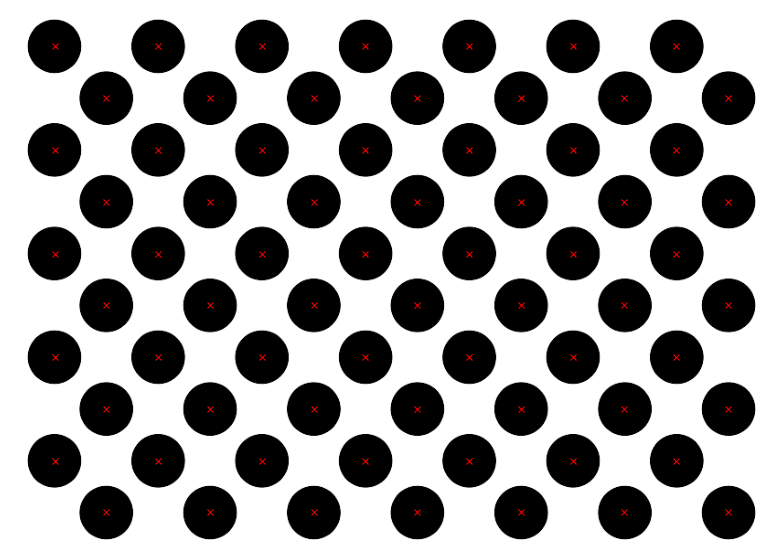

In [51]:
def processImageCircles(img):
    if img is None:
        print("Image is None!")
        return None

    # Setup SimpleBlobDetector parameters and the detector.
    blobParams = cv2.SimpleBlobDetector_Params()
    detector = cv2.SimpleBlobDetector_create(blobParams)

    # the shape of the pattern:
    # test pattern has 7 columns and 10 rows
    shape = (7,10)

    # find the circles. 
    found, corners = cv2.findCirclesGrid( img, shape, None, 
          flags = cv2.CALIB_CB_ASYMMETRIC_GRID, blobDetector = detector )
    
    if found: # refine corner with sub-pixel accuracy
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        corners = cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    else : #not found!
        print('circles not found')
        return None

    return corners.reshape(-1, 2)

img = cv2.imread( 'acircles.png', cv2.IMREAD_GRAYSCALE )
corners = processImageCircles( img )

# plot
plt.figure(figsize=(15,10))
imshow(img, cmap='gray')
plt.plot(corners[:,0], corners[:,1], 'rx')
plt.show()